In [1]:
import sys
sys.path.insert(0, '..')
# from transformer.models import DecoderOnlyModel
from data_utils.Datasets import SerializedConcatDataset, PermSerializedConcatDataset, BinarySerializer
import pickle
import torch
import numpy as np

from transformers import AutoConfig, GPT2LMHeadModel

In [2]:
with open('serializer.pkl', 'rb') as inp:
    binser = pickle.load(inp)

# define model
vocab_size = binser.vocab_size
d_model = 256
num_heads = 4
num_layers = 4
d_ff = 256
max_seq_length = binser.max_seq_length
dropout = 0.3

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=vocab_size,
    n_positions=max_seq_length,
    n_layer=num_layers,
    n_head=num_heads,
    pad_token_id=binser.padding,
    bos_token_id=binser.padding,
    eos_token_id=binser.padding,
    n_embd=d_ff
)
transformer = GPT2LMHeadModel(config).to(dev)

transformer = transformer.to(dev)

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transformer = transformer.to(dev)

saved_model_path = '../saved_models/melboost_GPT2_serialized/melboost_GPT2_serialized.pt'
transformer.load_state_dict(torch.load(saved_model_path), strict=False)

transformer.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(30, 256)
    (wpe): Embedding(1063, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=256, out_features=30, bias=False)
)

In [3]:
# load data to test
# load data
npz_path = '../data/augmented_and_padded_data.npz'
dataset = SerializedConcatDataset(npz_path, pad_to_length=max_seq_length)

In [4]:
x, mask = dataset.__getitem__(0)
# find start harmonization index
idx = np.where(x == binser.start_harmonizing)[0][0]
print(idx)
y = np.pad(x[:idx+1], (x.shape[0]-idx-1, 0))
print(x.shape)
print(y.shape)
with np.printoptions(threshold=np.inf):
    print(x)
    print(y)

784
(1063,)
(1063,)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 

In [5]:
x, mask = dataset.__getitem__(0)
# find start harmonization index
idx = np.where(x == binser.start_harmonizing)[0][0]
print(idx)
y = np.pad(x[:idx+1], (x.shape[0]-idx-1, 0))
# remove zeros from the beginning and append them to the end
idx = np.where(y == binser.start_melody)[0][0]
y = np.roll(y, -idx)
idx = np.where(x == binser.start_melody)[0][0]
x = np.roll(x, -idx)
print(x.shape)
print(y.shape)
with np.printoptions(threshold=np.inf):
    print(x)
    print(y)

784
(1063,)
(1063,)
[ 1  2  3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12
  2 14  2  3 12  2 10 14  2  7  2  7  2  4  7  2  6  2  4  7  2  6  2  6
 14  2  4  2  6 14  2  4  2  4  7  2  6  2  4  7  2  6 14  2 11  2 10  2
  3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12  2 14
  2  3 12  2 10 14  2 10  2 10  2 12  2 10  2  8  2  7  2 10  2  8  2  5
  7  2  3 12  2 14  2  3 12  2  7 14  2  3  2  3  2 15 16 17 19 22 26 16
 19 22 24 28 16 17 19 22 26 16 19 22 24 28 16 17 21 24 28 16 17 20 22 26
 16 19 21 24 28 16 18 21 24 26 16 17 19 22 26 16 19 22 24 28 16 17 19 22
 26 16 19 22 24 28 16 17 21 24 28 16 17 21 24 28 16 18 21 23 26 16 20 23
 26 28 16 18 21 23 26 16 20 23 26 28 16 20 21 25 28 16 18 21 24 26 16 20
 23 25 28 16 18 22 25 28 16 18 21 23 26 16 20 23 26 28 16 18 21 23 26 16
 20 23 26 28 16 20 21 25 28 16 19 22 24 28 16 17 19 22 26 16 19 22 24 28
 16 17 19 22 26 16 19 22 24 28 16 17 21 24 28 16 17 20 22 26 16 19 21 24
 28 16 18 21 24 26 16 17 19 22 

In [6]:
# inp = torch.from_numpy( np.expand_dims(y[1:], axis=0)).to(dev)
# inp = torch.from_numpy( np.expand_dims(y[:-1], axis=0)).to(dev)
inp = torch.from_numpy( np.expand_dims(x[:-1], axis=0)).to(dev)
with np.printoptions(threshold=np.inf):
    print(inp.cpu().numpy())
output = transformer(inp, attention_mask=inp != 0, output_attentions=True)
curr_idx = np.where(inp.cpu() == binser.start_harmonizing)[1][0]
print(curr_idx)

[[ 1  2  3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12
   2 14  2  3 12  2 10 14  2  7  2  7  2  4  7  2  6  2  4  7  2  6  2  6
  14  2  4  2  6 14  2  4  2  4  7  2  6  2  4  7  2  6 14  2 11  2 10  2
   3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12  2 14
   2  3 12  2 10 14  2 10  2 10  2 12  2 10  2  8  2  7  2 10  2  8  2  5
   7  2  3 12  2 14  2  3 12  2  7 14  2  3  2  3  2 15 16 17 19 22 26 16
  19 22 24 28 16 17 19 22 26 16 19 22 24 28 16 17 21 24 28 16 17 20 22 26
  16 19 21 24 28 16 18 21 24 26 16 17 19 22 26 16 19 22 24 28 16 17 19 22
  26 16 19 22 24 28 16 17 21 24 28 16 17 21 24 28 16 18 21 23 26 16 20 23
  26 28 16 18 21 23 26 16 20 23 26 28 16 20 21 25 28 16 18 21 24 26 16 20
  23 25 28 16 18 22 25 28 16 18 21 23 26 16 20 23 26 28 16 18 21 23 26 16
  20 23 26 28 16 20 21 25 28 16 19 22 24 28 16 17 19 22 26 16 19 22 24 28
  16 17 19 22 26 16 19 22 24 28 16 17 21 24 28 16 17 20 22 26 16 19 21 24
  28 16 18 21 24 26 16 17 19 22 26 16 

In [7]:
prediction = output.logits.argmax(dim=2, keepdim=True).squeeze()
z = prediction.cpu().numpy()
with np.printoptions(threshold=np.inf):
    print(z)
print(z[curr_idx])

[15 15 21 17 15 17 15 16 24 15 24 15 26 17 15 24 15 26 17 15 16 15 16 24
 15 17 15 21 24 15 16 16 15 24 15 16 15 16 24 15 24 15 16 24 15 16 15 16
 17 15 16 15 16 17 15 16 15 15 16 15 16 15 16 16 15 16 16 15 28 15 16 15
 15 16 15 16 15 15 16 15 16 15 26 16 15 16 15 16 16 15 16 15 15 16 15 16
 15 21 16 15 26 24 15 26 15 26 15 16 15 15 15 15 15 15 15 15 15 15 15 16
 15 15 15 16 15 16 15 15 16 15 15 15 15 15 15 15 15 16 17 21 22 26 16 17
 22 26 28 16 17 21 22 26 16 17 22 26 28 16 17 19 24 28 16 17 21 24 26 16
 19 21 24 28 16 17 21 24 26 16 17 19 22 26 16 19 22 24 28 16 17 21 22 26
 16 19 22 24 28 16 17 21 24 28 16 17 21 24 28 16 17 21 24 26 16 17 23 26
 28 16 19 21 23 26 28 20 23 26 28 16 20 23 23 28 16 19 21 23 26 28 17 23
 26 28 16 17 21 23 28 16 18 21 23 26 28 18 23 26 28 16 17 21 23 26 28 18
 23 26 28 16 20 23 23 28 16 19 21 24 26 16 18 21 21 24 16 18 22 24 26 16
 18 19 22 26 16 19 22 26 27 16 17 21 24 26 16 19 21 22 26 16 19 22 24 26
 16 17 21 24 26 16 17 19 22 26 16 17 22 26 26 16 17

In [8]:
a = output.attentions

In [9]:
print(a[0].shape)

torch.Size([1, 4, 1062, 1062])


In [10]:
import matplotlib.pyplot as plt

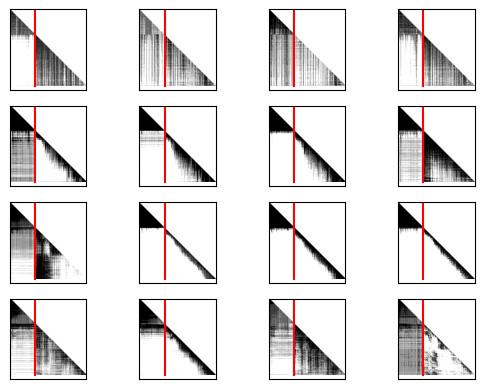

In [33]:
idx_pad = np.where(x == 0)[0][0]
idx_harm = np.where(x == binser.start_harmonizing)[0][0]
for l in range(4):
    for h in range(4):
        a_np = a[l][0,h,:idx_pad,:idx_pad].cpu().detach().numpy()
        plt.subplot(4,4,4*l+h+1)
        plt.imshow( a_np > np.mean(a_np), cmap='gray_r' )
        plt.plot([idx_harm, idx_harm],[0, idx_pad], 'r')
        plt.xticks([])
        plt.yticks([])

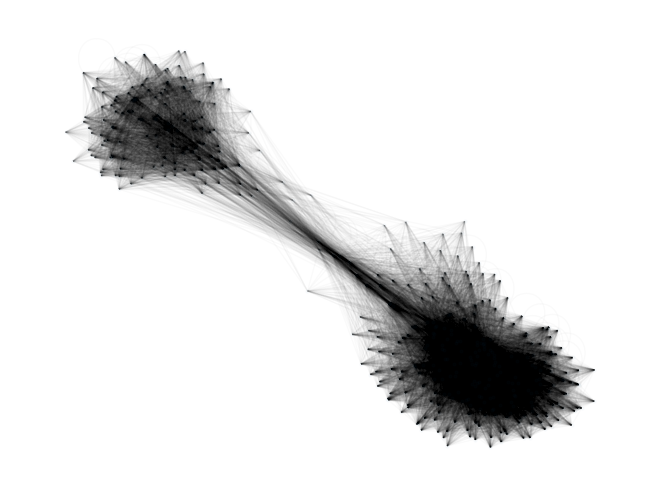

In [43]:
import matplotlib.pyplot as plt
import networkx as nx

a_np = a[0][0,0,:idx_pad,:idx_pad].cpu().detach().numpy()

adjacency_matrix = a_np > np.mean(a_np)

def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=5, alpha=0.02)
    # nx.draw(gr, node_size=500, labels=mylabels, with_labels=True)
    plt.show()

lst = list(range(adjacency_matrix.shape[0]))
["{:02d}".format(x) for x in lst]
show_graph_with_labels(adjacency_matrix, ["{:02d}".format(x) for x in lst])